# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

import nltk
nltk.download(['punkt', 'wordnet'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myleg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\myleg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('messages_categories', con=engine)
X = df[['message', 'genre']]
Y = df.iloc[:, 4:]

### 2. Write a tokenization function to process your text data

In [3]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

message_pipe = Pipeline([
    ('col_sel', ColumnSelector('message')),
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer())
    ])

genre_pipe = Pipeline([
    ('col_sel', ColumnSelector(['genre'])),
    ('encoder', OneHotEncoder(sparse=False))
])

ml_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('message_pipe', message_pipe),
        ('genre_pipe', genre_pipe)
        ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('message_pipe',
                                                 Pipeline(steps=[('col_sel',
                                                                  ColumnSelector(columns='message')),
                                                                 ('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x00000234D86CC160>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('genre_pipe',
                                                 Pipeline(steps=[('col_sel',
                                                                  ColumnSelector(columns=['genre'])),
                                                                 ('encoder',
                                

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [6]:
y_pred = ml_pipeline.predict(X_test)

In [7]:
y_test

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
13576,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
15688,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
5170,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24777,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19527,1,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
18030,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6270,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
696,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_pred_df = pd.DataFrame(y_pred, columns=Y.columns)
y_pred_df

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7804,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7805,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7806,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7807,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
test_result = defaultdict(list)
for col in Y.columns:
    f1 = f1_score(y_test[col], y_pred_df[col])
    prec = precision_score(y_test[col], y_pred_df[col])
    recall = recall_score(y_test[col], y_pred_df[col])
    test_result['f1_score'].append(f1)
    test_result['precision'].append(prec)
    test_result['recall'].append(recall)

C:\Users\myleg\Anaconda3\envs\cudapy38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\myleg\Anaconda3\envs\cudapy38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\myleg\Anaconda3\envs\cudapy38\lib\site-packages\sklearn\metrics\_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\myleg\Anaconda3\envs\cudapy38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetr

In [10]:
result_df = pd.DataFrame(test_result).T
result_df.columns = Y.columns
result_df

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
f1_score,0.884304,0.607824,0.0,0.681865,0.075873,0.080378,0.105727,0.0,0.041958,0.0,...,0.0,0.0,0.701320,0.532151,0.486436,0.0,0.783951,0.214689,0.014778,0.524472
precision,0.813555,0.875000,0.0,0.777561,0.625000,0.809524,0.857143,0.0,0.545455,0.0,...,0.0,0.0,0.848761,0.912548,0.809969,0.0,0.899115,0.730769,0.500000,0.842713
recall,0.968530,0.465643,0.0,0.607143,0.040388,0.042289,0.056338,0.0,0.021818,0.0,...,0.0,0.0,0.597522,0.375587,0.347594,0.0,0.694938,0.125828,0.007500,0.380704


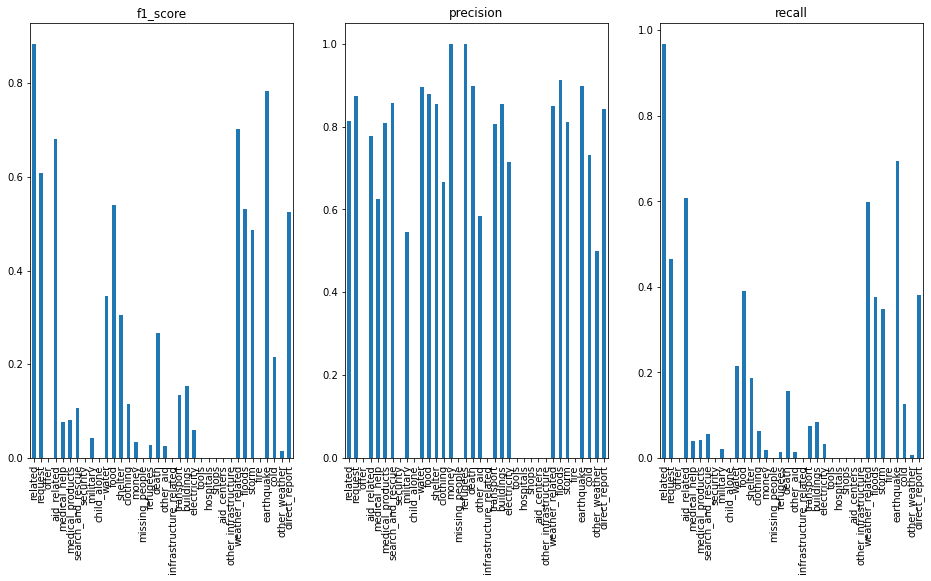

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
for i in range(result_df.shape[0]):
    result_df.iloc[i, :].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{result_df.index[i]}")


### 6. Improve your model
Use grid search to find better parameters. 

In [12]:
parameters = {'clf__estimator__bootstrap': [True, False],
 'clf__estimator__max_depth': [5, 10, 20, None],
 'clf__estimator__max_features': ['auto', 'sqrt'],
 'clf__estimator__min_samples_leaf': [1, 2, 4],
 'clf__estimator__min_samples_split': [2, 5, ],
 'clf__estimator__n_estimators': [75, 100, 150]}
cv = GridSearchCV(ml_pipeline, param_grid=parameters)

In [13]:
cv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
cv.best_params_

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
y_pred = cv.fit(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=Y.columns)

In [ ]:
test_result = defaultdict(list)
for col in Y.columns:
    f1 = f1_score(y_test[col], y_pred_df[col])
    prec = precision_score(y_test[col], y_pred_df[col])
    recall = recall_score(y_test[col], y_pred_df[col])
    test_result['f1_score'].append(f1)
    test_result['precision'].append(prec)
    test_result['recall'].append(recall)
result_df = pd.DataFrame(test_result).T
result_df.columns = Y.columns
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
for i in range(result_df.shape[0]):
    result_df.iloc[i, :].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{result_df.index[i]}")


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [ ]:
with open('disaster_response_classification_model.pkl', 'wb') as model_file:
    pickle.dump(ml_pipeline, model_file)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.